# Aula 1 - Algoritmos de Redução de Dimensionalidade - Análise de Componentes Principais

Na nossa primeira aula do novo módulo de Machine Learning, vamos continuar falando sobre algoritmos não-supervisionados, porém hoje teremos o foco em algoritmos de **redução de dimensionalidade**. Falaremos sobre os seguintes tópicos:

- Análise de Componentes Principais - PCA
- Aplicando PCA na análise exploratória de dados
- Aplicando PCA com o Pipeline
- Selecionando o número de componentes
- A matemática por trás do PCA

É comum que um problema de dados real possua muitas dimensões ou *features*, de modo que isso pode tornar o treinamento impraticável do ponto de vista de custo computacional além de tornar a solução tecnicamente difícil de ser encontrada. No entanto, conforme veremos ao final da aula, frequentemente é possível aplicar técnicas de redução dessa dimensionalidade, visto que nem sempre todas esses atributos são realmente importantes para a resposta.

Além disso, quanto mais dimensões o dataset possuir, maior será a quantidade de exemplos necessários para se generalizar um padrão existente. E isso cresce de maneira exponencial. Pensemos no seguinte caso: estamos interessados em prever se uma determinada ação vai subir ou descer, baseando-se em regras. Nossa análise assume que valores discretos são permitidos apenas para os atributos.

- **se o faturamento for maior que R$ 1 bi, a ação sobe...** - aqui analisamos uma única dimensão (faturamento) e portanto precisamos conhecer apenas o faturamento
- **mas, se a taxa de juros estiver muito alta, a ação pode descer ou subir, dependendo do faturamento...** - duas dimensões (faturamento, taxa de juros), sendo necessário, no mínimo, 4 casos de análise (faturamento > 1 bi, juros baixos; faturamento < 1 bi, juros baixos; faturamento > 1 bi; juros altos; faturamento < 1 bi, juros altos)
- **também importante considerar o volume de ações para determinar se sobe ou desce** - três dimensões, com 27 casos a serem analisados
- com 10 atributos, são necessários 1000 registros de situações para nosso sistema de regras entender o que acontece em cada caso e poder responder o que fazer.
- com 100 atributos, 1.000.0000 de registros. E assim por diante.

Isso ilustra para um exemplo simples, onde somente situações discretas de cada atributo existem. Imaginem como isso fica absurdamente impraticável com atributos contínuos que podem se combinar de diversas formas. Com muitas dimensões, o modelo de aprendizado pode não ter registros o suficiente para entender registros diferentes entre si, levando a um desempenho inadequado. Isso é conhecido como *Maldição da Dimensionalidade*, um fenômeno comum em conjuntos de dados de alta dimensionalidade. Felizmente, temos técnicas bem interessantes para lidar com esse tipo de situação.

## **1. Análise de Componentes Principais - PCA**

O termo PCA vem do inglês *Principal Component Analysis* e denomina uma técnica **não-supervisionada** que realiza uma transformação das variáveis originais num novo espaço de *features*, de modo que as novas componentes cartesianas (as *componentes principais*) sejam **ortogonais entre si** e representem a direção da **máxima variância** dos dados originais. Assim sendo:

> A primeira componente principal é um eixo cartesiano que maximiza a variância dos dados projetados em sua direção<br>A segunda componente principal é um outro eixo cartesiano, ortogonal ao primeiro, que também maximia a variância nesta direção.

<img src=https://austingwalters.com/wp-content/uploads/2014/11/gaussDist-labeled.png width=400>

Fatos importantes sobre os resultados da análise de componentes principais:

- Se o espaço original tem $n$ atributos, então será possível construir $n$ componentes principais
- Cada componente principal é uma **combinação linear dos atributos originais**. Ao contrário dos algoritmos de seleção de atributos que eliminam definitivamente as colunas do conjunto de dados, a análise de componentes principais (e outras de redução de dimensionalidade) promovem a combinação desses atributos em novos espaços
- As componentes principais são ortogonais entre si, 
- As componentes principais são linearmente independentes entre si, sendo que a PCA também pode ser utilizada para eliminar multicolinearidade antes da modelagem.

Com a aplicação da PCA, é espera-se que, no **espaço transformado das componentes principais**, a variância completa ou aproximadamente completa dos dados esteja contida nas $L$ primeiras componentes principais ($L < n$).

Em resumo, as principais aplicações da PCA podem ser elencadas:

- evitar a Maldição da Dimensionalidade
- Acelerar o treinamento de modelos, visto que os algoritmos têm menor quantidade de colunas para considerar
- Fornecer dados sem colinearidade
- Visualização de dados e análise exploratória de dados
- Eliminar ruído de medição

### **1.1. Interpretação das Componentes Principais**

Conforme dito, cada componente principal é uma **combinação linear dos atributos originais**. Assim sendo, o PCA pode ser interpretado como um **método que constrói um novo espaço de atributos** ou seja, um *feature map*. Isso é bem semelhante ao que é feito para os algoritmos de *Kernel SVM* que verificamos no módulo de ML2. No entanto, no caso do SVM, os novos espaços criados pela aplicação da *kernel function* eram sempre de dimensão superior ao dataset original. Em contrapartida, a PCA sempre produzirá um espaço com dimensão igual ou menor ao dataset original.

<img src=https://miro.medium.com/max/1200/1*V3JWBvxB92Uo116Bpxa3Tw.png width=700>

Sabendo que os novos atributos são ortogonais entre sim, elas maximizam a variância dos dados em cada sub-espaço de projeção.

Na prática, seja um espaço de input $\mathcal{X}$ de $n$ dimensões, tal que cada vetor de features $\vec{x} \in \mathcal{X}$ é dado por:

$ \vec{x} = \left ( x_1, x_2, x_3, \cdots , x_n \right) $

Após a aplicação do PCA, estaremos no espaço de componentes principais, tal que um vetor de features neste espaço, $\vec{x}_{PC}$, será dado por:

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, \cdots , PC_n \right) $

Onde cada componente principal é uma combinação linear das features originais, isto é, 

$ PC_i = \sum_{k=1}^n \alpha_{i, k} x_k = \alpha_{i, 1} x_1 +  \alpha_{i, 2} x_2 + \cdots +  \alpha_{i, n} x_n$

Note que cada componente principal $i$ tem $n$ coeficientes diferentes $\alpha_{i, k}$, que acompanham cada uma das features $k$ do espaço original. Esse coeficientes $\alpha_{i,k}$ podem ser utilizados como forma de geradores de *insights* a respeito da estrutura dos dados, sendo comumente chamados de *efeitos* ou *pesos*. Vamos começar com um exemplo simples.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, \
    RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# carregar os dados
iris = load_iris(as_frame=True)
x = iris.data
y = pd.DataFrame(iris.target.values, columns=['species'])

In [3]:
# separando entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2,
    random_state=42, stratify=y
)

No caso do dataset iris, temos 4 features, de modo que o espaço original tem 4 dimensões, e um vetor de features é:

$ \vec{x} = (x_1, x_2, x_3, x_4)$.

Sendo que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Assim, esperamos que após o PCA, o espaço de componentes principais também tenha 4 dimensões, isto é, 

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, PC_4 \right) $

E as componentes principais serão: 

$ PC_1 = \alpha_{1, 1} x_1 + \alpha_{1, 2} x_2 + \alpha_{1, 3} x_3 + \alpha_{1, 4} x_4$

$ PC_2 = \alpha_{2, 1} x_1 + \alpha_{2, 2} x_2 + \alpha_{2, 3} x_3 + \alpha_{2, 4} x_4$

$ PC_3 = \alpha_{3, 1} x_1 + \alpha_{3, 2} x_2 + \alpha_{3, 3} x_3 + \alpha_{3, 4} x_4$

$ PC_4 = \alpha_{4, 1} x_1 + \alpha_{4, 2} x_2 + \alpha_{4, 3} x_3 + \alpha_{4, 4} x_4$

O algoritmo de PCA é bem sensível à ordem de grandeza dos atributos, visto que ele depende do cálculo das variâncias e covariâncias, como veremos posteriormente. Além disso, uma das hipóteses que ele faz a respeito dos dados é que eles estejam **centrados em relação à média**. Portanto, a padronização é a transformação indicada para a utilização do PCA.

In [4]:
# aplicação do padronizador
scaler = StandardScaler().fit(x_train)

x_train_s = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns,
                         index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns,
                        index=x_test.index)

Para a aplicação do algoritmo de PCA, utilizaremos o objeto `PCA`, do `scikit-learn`, cuja documentação pode ser encontrada [nesse link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [5]:
# aplicação do objeto da PCA
pca = PCA(random_state=42).fit(x_train_s)

In [6]:
# coeficientes das combinações lineares - efeitos ou pesos
pca.components_

array([[ 0.52679335, -0.25307206,  0.58186918,  0.56557189],
       [ 0.34813945,  0.93470791,  0.02689438,  0.06630793],
       [-0.72745724,  0.22196252,  0.1386138 ,  0.6342908 ],
       [ 0.26850263, -0.11405393, -0.80093144,  0.52288323]])

O atributo `components_` nos apresenta os coeficientes das combinações lineares $\alpha_{i,k}$ de cada componente principal e podem ser utilizados como uma forma de análise exploratória dos dados.

In [7]:
for j in range(pca.n_components_):
    
    string = (f"PC_{j+1} = " 
              + 
              " + ".join([f"({alpha:.3f})*x_{i+1}" for i, alpha in enumerate(pca.components_[j])])
              +
              "\n")
    
    print(string)

PC_1 = (0.527)*x_1 + (-0.253)*x_2 + (0.582)*x_3 + (0.566)*x_4

PC_2 = (0.348)*x_1 + (0.935)*x_2 + (0.027)*x_3 + (0.066)*x_4

PC_3 = (-0.727)*x_1 + (0.222)*x_2 + (0.139)*x_3 + (0.634)*x_4

PC_4 = (0.269)*x_1 + (-0.114)*x_2 + (-0.801)*x_3 + (0.523)*x_4



Ou seja,

$PC_1 = 0.527x_1 -0.253x_2 + 0.582x_3 + 0.566x_4$

$PC_2 = 0.348x_1 + 0.935x_2 + 0.027x_3 + 0.066x_4$

$PC_3 = -0.727x_1 + 0.222x_2 + 0.139x_3 + 0.634x_4$

$PC_4 = 0.269x_1 -0.114x_2 -0.801x_3 + 0.523x_4$

Construindo-se um gráfico de combinações em pares de componentes principais, podemos usar os coeficientes para determinar pontos parecidos e, assim, inferir a respeito da estrutura dos dados. Por exemplo, espécies com maiores 'sepal_lenght' tendem a serem agrupadas com valores maiores de $PC_1$, visto que o coeficiente associado é positivo. No entanto, maiores $PC_1$ tendem a possuir exemplares com menores 'sepal_width', visto que o coeficiente associado é negativo.

No entanto, é de se pensar de que ao mesmo tempo que reduzimos a dimesionalidade, perdemos em alguma outra coisa. Essa coisa é a informação. Quando paramos de olhar para todas as componentes principais, deixamos de extrair a informação intrínseca a essas componentes. Mesmo assim, essa informação "perdida" pode ser tão irrelevante, de forma que os resultados finais tem pouco ou nenhum impacto. Para entender como isso acontece, precisamos analisar qual a fração de variância explicada por cada componente.

In [8]:
# criando uma lista de labels
labels = [f'PC_{i+1}' for i in range(pca.n_components_)]

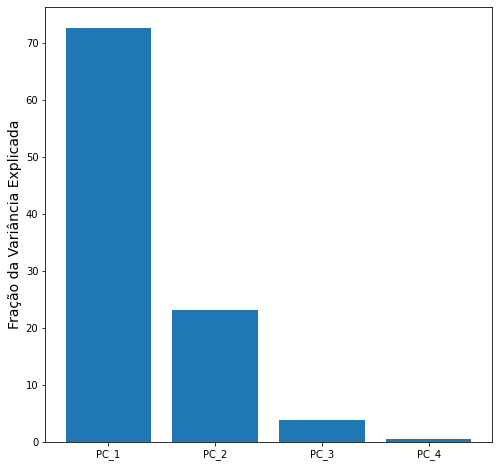

In [9]:
# construindo um gráfico de variância explicada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca.explained_variance_ratio_*100)
plt.ylabel('Fração da Variância Explicada', size=14)
plt.show()

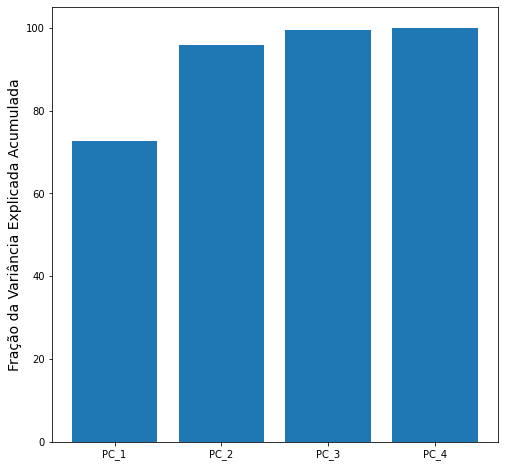

In [10]:
# construindo um gráfico de variância explicada acumulada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca.explained_variance_ratio_.cumsum()*100)
plt.ylabel('Fração da Variância Explicada Acumulada', size=14)
plt.show()

Os gráficos mostram que, selecionando apenas as duas primeiras componentes principais, extraímos cerca de 95 % da informação original, porém reduzido a dimensionalidade original pela metade.

Esse tipo de análise é interessante para determinar o quanto de informação estaria sendo levada para uma possível modelagem futura. Nesse caso, estamos garantindo que modelando com 2 componentes principais, estamos retendo praticamente toda a informação inicial.

> Veja que a escolha de $L < n$ componentes principais pode ser vista como um procedimento de **feature selection**, mas feito **no espaço de componentes principais!**
> Como não são as features originais que são selecionadas, é comum nos referirmos a este procedimento como **redução de dimensionalidade** (e a dimensionalidade que é reduzida é do espaço de componentes principais)

De fato, note que **todas as 4 features originais** estão presentes em cada uma das PCs, como termos da combinação linear que define cada PC. E, naturalmente, todas as 4 estão presentes nas $L$ primeiras.

Mas como podemos aplicar a PCA em análise exploratória de dados?

## **2. PCA aplicada à análise exploratória de dados**

Um uso importante do algoritmo de PCA é na **interpretabilidade** dos dados de alta dimensionalidade. Nossa compreensão cognitiva nos limita a enxergar o mundo em 3 dimensões e, mesmo em 3 dimensões, pode ser difícil de enxergar estruturas claras dos dados. Sabendo que as componentes principais possuem todas os atributos originais em sua composição, podemos contruir gráficos bidimensionais para entender essas relações de forma mais simples.

<Figure size 576x576 with 0 Axes>

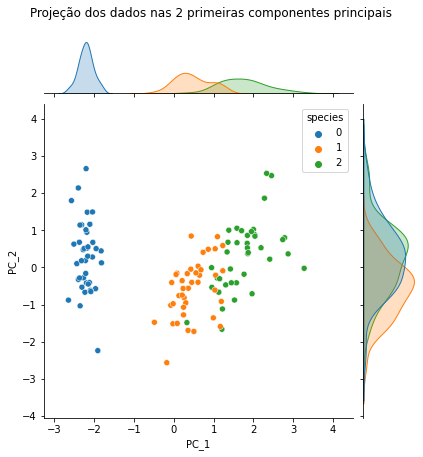

In [11]:
# transformando os dados de treino e plotando as duas primeiras componentes
x_train_pca = pd.DataFrame(pca.transform(x_train_s), columns=labels,
                           index=x_train_s.index)

# obtendo os valores das espécies
data_train_pca = pd.concat([x_train_pca, y_train], axis=1)

plt.figure(figsize=(8, 8))
g = sns.jointplot(data_train_pca['PC_1'], data_train_pca['PC_2'],
         hue=data_train_pca['species'], palette='tab10')
g.fig.suptitle('Projeção dos dados nas 2 primeiras componentes principais',
               y=1.05)
plt.show()

Nota-se, neste exemplo, que a espécie 0 ('setosa') é linearmente separável das outras, possuindo baixos valores de $PC_1$. Pela análise anterior dos pesos da primeira componente, isso nos leva à conclusão de que essa espécie comumente possuem os menores valores de 'sepal_lenght', porém os maiores valores de 'sepal_width', em relação às outras espécies.

<hr>

**Exercício 1** Utilizando a base de dados `heart.csv`, vamos tentar desenvolver um diagnosticador simples a respeito do risco de um ataque cardíaco. Para isso, aplique o algoritmo de PCA de forma exploratória, nos seguintes passos:

- cheque a presença de valores ausentes
- selecione somente atributos numéricos
- realize o escalonamento com `StandardScaler`
- por meio de gráficos bidimensionais, dê uma sugestão do que pode ser usado para diagnosticar um alto risco de ataque cardíaco.

Segue o dicionário de dados, retirado da origem dos dados ([esse link](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?resource=download&select=heart.csv)):

- `age`: idade da pessoa
- `sex`: gênero
- `cp`: tipo de dor no peito (1 - angina típica, 2 - angina atípica, 3 - dor não angínica, 4 - sem dor)
- `exang` - se houve angina induzida por exercício (1 - sim, 0 - não)
- `trtbps` - batimentos por segundo em estado de repouso
- `chol` - concentração de colesterol
- `fbs` - concentração de açúcar no sangue > 120 mg/dl (1 - sim, 0 - não)
- `restecg` - resultados do eletrocardiograma em estado de repouso (0 - normal, 1 - anormalidades de onda do sinal; 2 - provável ou definitiva hipertrofia do ventrículo esquerdo)
- `thalachh` - máxima taxa de batimentos cardíacos alcançados
- `target` - 0 - menor chance de ataque cardíaco, 1 - maior chance

<hr>

In [12]:
# carregando dados
data_heart = pd.read_csv('./data/heart.csv')
data_heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [26]:
# separando preditores
x = data_heart.drop(['output'], axis=1)

In [27]:
# checando dados nulos
x.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
dtype: int64

In [28]:
# aplicando scaler
scaler = StandardScaler().fit(x)
x_s = pd.DataFrame(scaler.transform(x), columns=x.columns, index=x.index)

In [39]:
# aplicando a PCA
pca_heart = PCA(random_state=42).fit(x_s)

# criando as labels
labels = [f'PC{i+1}' for i in range(pca_heart.n_components_)]

# verificando componentes
pd.DataFrame(pca_heart.components_, index=labels, columns=x_s.columns)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
PC1,0.314203,0.090838,-0.274607,0.183920,0.117375,0.073640,-0.127728,-0.416498,0.361267,0.419639,-0.379772,0.273262,0.222024
PC2,0.406149,-0.377792,0.297266,0.438187,0.364514,0.317433,-0.220882,0.077876,-0.263118,-0.052255,0.048374,0.094147,-0.200720
PC3,-0.094077,0.554849,0.356974,0.203849,-0.407825,0.481736,-0.089191,0.158255,-0.126356,0.110343,-0.073818,0.183569,0.125011
PC4,-0.020662,-0.255309,0.287900,0.022601,-0.343410,-0.068605,0.266096,-0.184125,-0.115056,0.326296,-0.494849,-0.328016,-0.389191
PC5,-0.307153,0.050704,0.163179,0.188138,0.320067,-0.233442,-0.393667,0.323284,0.034536,0.250579,-0.246823,-0.435365,0.331950
PC6,-0.128296,0.054969,-0.193411,-0.179460,-0.104730,0.249614,-0.666813,-0.120984,0.230699,-0.170080,-0.064069,-0.182107,-0.508857
PC7,-0.223730,-0.162507,-0.215390,0.332763,0.049329,0.510818,0.396896,0.101473,0.449919,-0.112888,0.055038,-0.337606,0.055165
PC8,-0.262477,-0.175992,0.047950,-0.595334,0.372381,0.432863,0.099841,0.143461,-0.112607,0.192323,-0.261807,0.259678,0.034349
PC9,-0.379000,-0.198925,-0.351432,0.350392,-0.153975,-0.177004,-0.038304,0.372044,-0.058500,0.233603,-0.028505,0.485808,-0.284201
PC10,-0.016722,0.535619,0.164351,0.071524,0.495170,-0.153696,0.269966,0.030813,0.198732,0.111384,0.055934,0.035325,-0.530831


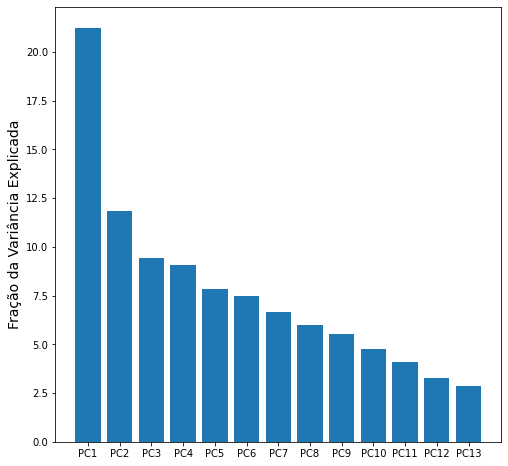

In [40]:
# analisar explicabilidade de variância
plt.figure(figsize=(8, 8))
plt.bar(labels, pca_heart.explained_variance_ratio_*100)
plt.ylabel('Fração da Variância Explicada', size=14)
plt.show()

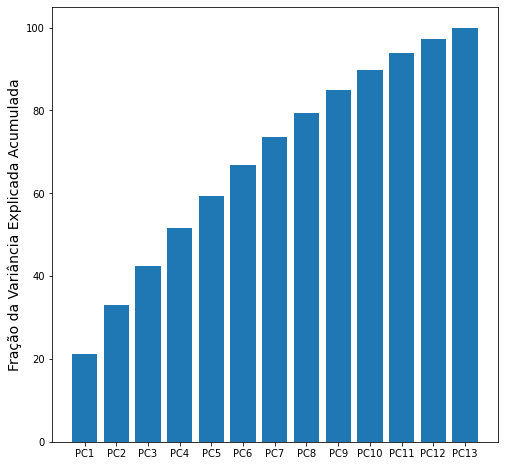

In [41]:
# analisar explicabilidade de variância acumulada
plt.figure(figsize=(8, 8))
plt.bar(labels, pca_heart.explained_variance_ratio_.cumsum()*100)
plt.ylabel('Fração da Variância Explicada Acumulada', size=14)
plt.show()

In [46]:
# gráfico das primeiras componentes
data_heart_pca = pd.DataFrame(pca_heart.transform(x),
                              columns=labels,
                              index=x.index)
data_heart_pca['output'] = data_heart['output']
data_heart_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,output
0,11.864702,186.248176,-45.167296,-104.756764,132.212648,-77.829681,60.367984,6.301796,45.683104,129.914310,-47.035020,45.971132,58.695061,1
1,-11.679591,177.094657,-47.527101,-117.160015,155.088452,-79.494879,65.807772,33.578912,61.915556,138.696324,-45.994936,55.409312,64.730387,1
2,-10.903849,161.291356,-32.719277,-100.657536,133.447428,-72.341452,61.449752,12.348289,61.942833,114.297456,-40.902859,56.585247,60.908646,1
3,-7.061675,174.566104,-47.870334,-113.472331,138.647280,-77.058346,57.255663,26.949868,49.681580,130.100442,-46.422706,64.949950,65.600289,1
4,13.811363,216.644623,-99.521836,-151.466377,171.029269,-87.326807,62.181100,68.453343,25.997976,187.528058,-58.610468,34.956374,60.356609,1


<Figure size 576x576 with 0 Axes>

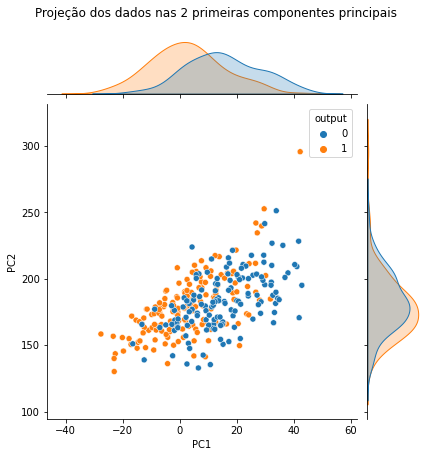

In [51]:
plt.figure(figsize=(8, 8))
g = sns.jointplot(data_heart_pca['PC1'], data_heart_pca['PC2'],
         hue=data_heart_pca['output'], palette='tab10')
g.fig.suptitle('Projeção dos dados nas 2 primeiras componentes principais',
               y=1.05)
plt.show()

Analisando-se o efeito da idade, verifica-se que o coeficiente é positivo para a PC1 e positivo para a PC2. Isso significa que aumentar a idade (pessoas mais velhas) têm maior valor de PC1 e PC2. Pelo gráfico bidimensional, não fica claro se isso implica numa maior chance de ataque cardíaco - há muita mistura de pontos. No entanto, outro fator interessante é que a variável restecg (resultados do eletrocardiogram no estado de repouso) têm fator negativo na PC1, de forma que maiores valores apontam para menores PC1s. De fato, o gráfico mostra ligeiramente maior concentração de pontos laranja (pessoas com ataque cardíaco) em menores valores de PC1.

<hr>

## **3. PCA no Pipeline**

Conforme já mencionado, além de servir para reduzir a dimesionalidade, a PCA pode ser aplicada para gerar atributos independentes entre si, visto que alguns algoritmos assumem a independência. Assim sendo, podemos aplicar o PCA dentro dos pipelines de modelagem que já aprendemos.

In [13]:
# para demonstração, vamos treinar o modelo sem PCA
pipe_no_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])
pipe_no_pca.fit(x_train, y_train)

# realizar predições
yhat = pipe_no_pca.predict(x_test)

# avaliar métricas
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [14]:
# vamos fazer uma análise agora, usando somente 2 componentes
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model', LogisticRegression(random_state=42))
])

pipe_pca.fit(x_train, y_train)

# realizando novas predições
yhat_pca = pipe_pca.predict(x_test)

# analisando as métricas
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



Verifica-se que o modelo de regressão logística conseguiu compreender os padrões com o mesmo desempenho de classificação do que aquele treinado com todas os atributos. No caso do dataset utilizado, isso quase não fez diferença, mas é um fator que se deve levar em consideração quando trabalhamos com milhões de linhas e, em alguns casos, milhares de colunas.

Mas até o momento, estamos fazendo a seleção do número de componentes de forma bem manual. Vejamos quais são as possíveis formas de se realizar a seleção da quantidade de componentes principais a serem retidas.

## **4. Selecionando o Número de Componentes**

Existem alguns métodos listados em literatura que podem ajudar na seleção do número de componentes principais a serem retidas. Vejamos os mais conhecidos:

- Seleção manual - absoluta ou por variância relativa
- Validação cruzada
- Método do cotovelo
- Método da análise paralela

### **4.1. Seleção Manual**

A seleção manual é o que já temos feito até o momento. Se for absoluta, especifica-se quantas componentes são desejadas. Se for por variância relativa, especifica-se qual a fração mínima de variância original a ser retida.

In [15]:
# especificando-se uma retenção mínima de variância de 80 % da original
pca_var = PCA(n_components=0.80).fit(x_train_s)

print(f'Foram retidas {len(pca_var.components_)} componentes')
print(pca_var.explained_variance_ratio_)

Foram retidas 2 componentes
[0.72677234 0.23066667]


Verificam-se que o total das variâncias explicadas ultrapassa o valor estipulado. Mas o algoritmo retém componentes até que o mínimo especificado seja alcançado ou ultrapassado.

### **4.2. Método do Cotovelo**

Bem semelhante ao realizado para os métodos de vizinhos mais próximos (kNN e KMeans), o método do cotovelo analisa quando a variância retida já não aumenta significativamente a variaância acumulada. Isso é matematicamente conhecido como *ponto de inflexão*.

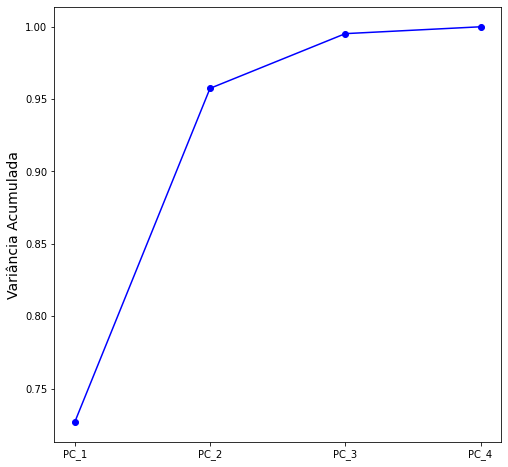

In [16]:
# reconstruindo o gráfico de variâncias acumuladas
plt.figure(figsize=(8, 8))
plt.plot(range(4), pca.explained_variance_ratio_.cumsum(), 'bo-')
plt.xticks(range(4), labels=labels)
plt.ylabel('Variância Acumulada', size=14)
plt.show()

### **4.3. Validação Cruzada**

Se o propósito for utilizar a PCA em modelagem, podemos tentar selecionar o número de componentes por meio de um algoritmo de busca com validação cruzada. Neste caso, não estamos muito interessados na interpretabilidade do modelo, mas sim em desempenho. O número de componentes é visto como um *hiperparâmetro* adicional a ser buscado.

In [17]:
# criando objeto amostrador
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando o pipeline de modelagem
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('model', LogisticRegression(solver='saga'))
])

# criando o dicionário de parâmetros
params = {
    'pca__n_components': [1, 2, 3, 4],
    'model__C': np.random.uniform(0.01, 10, 1000),
    'model__penalty': ['l1', 'l2']
}

# criando o selecionador de modelos
model_selector = RandomizedSearchCV(
    estimator=pipe_pca,
    param_distributions=params,
    n_iter=100,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=cvs
)

# ajustando o selecionador de modelos
model_selector.fit(x_train, y_train.values.ravel())

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(random_state=42)),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__C': array([8.01623344, 4.14294259, 4.69987615, 8.82780422, 4.55607285,
       3.73687993, 8.18189355, 4.34...
       3.37364891, 3.12404902, 3.84023159, 2.42580974, 8.67770983,
       7.63436269, 8.13163013, 9.39359968, 7.23678177, 2.09581179,
       0.18533768, 0.92077897, 3.21016332, 1.535166  , 1.61032373,
       7.10335147, 7.32359984, 8.82620191, 6.52317223, 3.64901606,
       4.85840189, 4.34950206, 9.44610181, 0.17386596, 8.84486696]),
                                        'model__penalty': ['l1', 'l2'],
                  

In [18]:
# analisando os melhores hiperparâmetros
print(model_selector.best_params_)

{'pca__n_components': 4, 'model__penalty': 'l1', 'model__C': 9.330590539008483}


In [19]:
# analisando o desempenho do melhor estimador
print(model_selector.best_score_)

0.9666666666666666


In [20]:
# desempenho na base de teste
yhat = model_selector.best_estimator_.predict(x_test)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Nesse caso, o melhor estimador considerou todas as componentes principais como importantes para melhorar o desempenho do modelo em relação aos modelos anteriores. Mas se a dimensionalidade é a mesma, qual seria vantagem de utilizar o PCA nesse caso? - *Ausência de multicolinearidade*

### **4.4. Método da Análise Paralela**

Trata-se de um método clássico reportado em literatura. Essencialmente, compara-se a variância retida no PCA aplicado ao dataset original com o PCA aplicado num dataset simulado, totalmente livre de multicolinearidade. O número de componentes a serem retidas é aquele cuja variância retida no dataset original é maior pela última vez que a variância retida no dataset simulado. Vejamos como isso acontece:

- Realizar uma cópia do dataset original
- Para cada coluna:
    - simular uma distribuição normal, com mesma média e desvio padrão da original
- aplicar a PCA no dataset original, com dimensão igual ao dataset
- aplicar a PCA no dataset simulado, com dimnesão igual ao dataset
- comparar a variância retida em cada um dos datasets

In [21]:
# cópia do dataset a ser estudado
x_train_fake = x_train.copy()

# subsituir as colunas da cópia por uma amostragem aleatória da distribuição
# normal, com mesma média e desvio padrão
for col in x_train_fake.columns:

    # calcula as estatísticas
    avg = x_train_fake[col].mean()
    std_ = x_train_fake[col].std()

    # realizar amostragem aleatória normal
    x_train_fake[col] = np.random.normal(loc=avg, scale=std_, 
                                         size=x_train.shape[0])

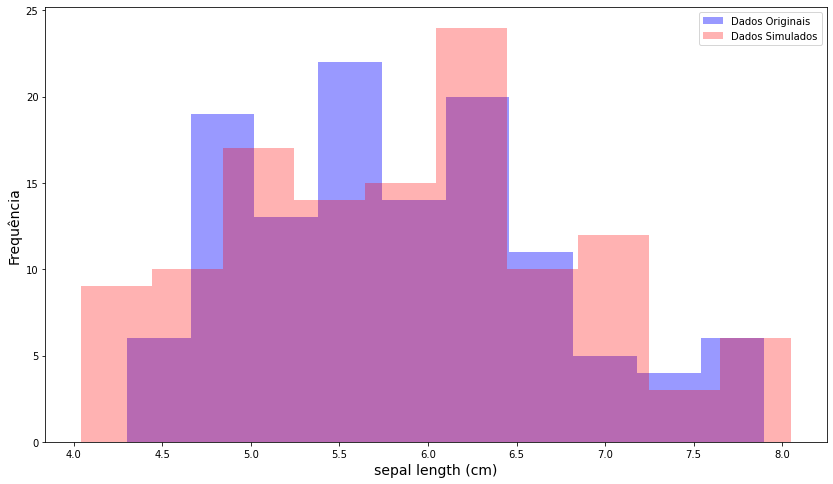

In [22]:
# comparar distribuições
plt.figure(figsize=(14, 8))
plt.hist(x_train.iloc[:, 0], color='blue', alpha=0.4, label='Dados Originais')
plt.hist(x_train_fake.iloc[:, 0], color='red', alpha=0.3, label='Dados Simulados')
plt.legend(loc='best')
plt.xlabel(x_train.columns[0], size=14)
plt.ylabel('Frequência', size=14)
plt.show()

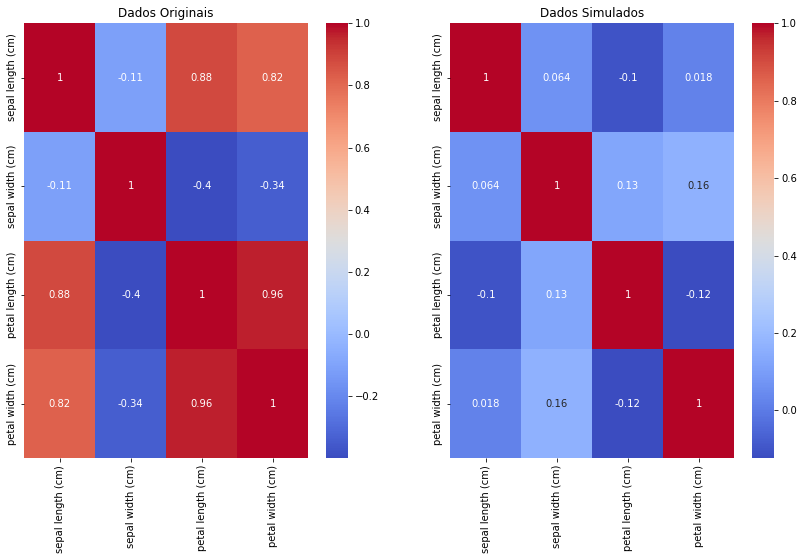

In [23]:
# checando correlações cruzadas
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(x_train.corr(), cmap='coolwarm', annot=True)
plt.title('Dados Originais')

ax = fig.add_subplot(1, 2, 2)
sns.heatmap(x_train_fake.corr(), cmap='coolwarm', annot=True)
plt.title('Dados Simulados')
plt.show()

In [24]:
# aplicando as PCAs em cada uma das colunas
pipe_real = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42))
])

pipe_fake = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42))
])

# ajuste
pipe_real.fit(x_train)
pipe_fake.fit(x_train_fake)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(random_state=42))])

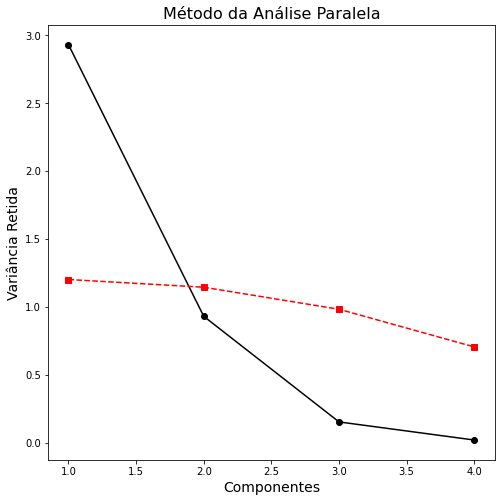

In [25]:
# construindo scree plot comparativo
plt.figure(figsize=(8, 8))
plt.plot(range(1, 5), pipe_real['pca'].explained_variance_, 'ko-', 
         label='Dados Originais')
plt.plot(range(1, 5), pipe_fake['pca'].explained_variance_, 'rs--', 
         label='Dados Simulados')
plt.ylabel('Variância Retida', size=14)
plt.xlabel('Componentes', size=14)
plt.title('Método da Análise Paralela', size=16)
plt.show()

Nesse caso, o número de componentes a ser considerado, deveria ser apenas 1.

<hr>

**Exercício 2** Construa um modelo de classificação para o risco de ataque cardíaco. Requisitos:

- utilize Pipeline
- compare os desempenhos de classificação usando todos os métodos de seleção do número de componentes principais, com exceção da seleção manual.

<hr>

<hr>

**Exercício 3 [DESAFIO]** Utilizando o dataset `german_credit_data.csv`, realize um mini-projeto exploratório e de modelagem utilizando PCA. Para isso:

- verifique dados nulos
- selecione apenas variáveis numéricas
- utilize modelagem por Pipeline
- faça PCA para análise exploratória e tente produzir *insights* a respeito do que torna uma pessoa adimplente ou o contrário
- escalonamento por `StandardScaler`
- o modelo a ser escolhido é livre
- faça otimização de hiperparâmetros com `RandomizedSearchCV` e `StratifiedKFold`
- compare o desempenho do modelo classificado para todos os métodos de seleção de componentes principais aprendidos.

<hr>

## **5. A Matemática do PCA**

Considere a matriz de features $X_{N \times n}$

> $N$ linhas (observações), cada uma caracterizada por $n$ features no espaço original.

Cada observação $i$ é caracterizada pelo vetor de features $\vec{x}_i = (x_{i1}, x_{i2}, \cdots, x_{in}$), que são as linhas da matriz de features:

$$
  X = \left [ \begin{array}{ccccc}
x_{11} & x_{12} & x_{13} & \cdots & x_{1n}\\ 
x_{21} & x_{22} & x_{23} & \cdots & x_{2n}\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
x_{N1} & x_{N2} & x_{N3} & \cdots & x_{Nn}\\ 
   \end{array} \right ] 
$$

### Passo 1 - Escalonamento

Para dados em que as features originais $x_j$ estão em escalas diferentes, é necessário escalar os dados para que eles tenham média 0 e desvio padrão 1 (ou seja, usamos o `StandardScaler`). 

Isso porque os componentes são influenciados pela escala das variáveis, justamente porque as matrizes de covariâncias, $\Sigma$ ou $\hat{\Sigma} = S$, são sensíveis à escala de um par de variáveis. 

Considere:

- $\bar{x}_j$ a média da variável $x_j$; 
- $s(x_j)$ o desvio padrão de $x_j$; 

Sendo $i = 1, 2,3,4,\cdots, N$ e $j = 1, 2,3,4,\cdots, n$.

Com isso, a padronização pode ser realizada por meio da equação abaixo: 

- Média 0 e desvio padrão 1: 

$$ \tilde{x}_{ij}= \frac{x_{ij}-\bar{x_j}}{s(X_j)} $$ 

<br>

### Passo 2 - Cálculo da matriz de covariância

Calcular a matriz de **covariância**/**correlação**, que são dadas por:

$$
  S = \left [ \begin{array}{ccccc}
\hat{Var}(x_1) & \hat{Cov}(x_1x_2) & \hat{Cov}(x_1x_3) & \cdots & \hat{Cov}(x_1x_n)\\ 
\hat{Cov}(x_2x_1) &\hat{Var}(x_2)& \hat{Cov}(x_2x_3) & \cdots & \hat{Cov}(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
\hat{Cov}(x_nx_1) & \hat{Cov}(x_nx_2)  & \hat{Cov}(x_nx_3)  & \cdots & \hat{Var}(x_n)\\ 
   \end{array} \right ] 
$$

<br>
<br>

$$
  R = \left [ \begin{array}{ccccc}
1 & r(x_1x_2) & r(x_1x_3) & \cdots & r(x_1x_n)\\ 
r(x_2x_1) & 1 & r(x_2x_3) & \cdots & r(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
r(x_nx_1) & r(x_nx_2)  & r(x_nx_3)  & \cdots & 1\\ 
   \end{array} \right ] 
$$

Em que:

$$
 \begin{array}{ccc}
\hat{Var}(x_j) = \frac{\sum_{i=1}^{N}(x_{ij}-\bar{x}_j)}{N-1}, & 
\hat{Cov}(x_{j1},x_{j2}) = \frac{\sum_{i=1}^N(x_{ij1}-\bar{x_{j1}})(x_{ij2}-\bar{x_{j2}})}{N-1}, &
r(x_{j1},x_{j2}) = \frac{\hat{Cov}(x_{j1},x_{j2})}{S_{xj1}S_{xj2}}
   \end{array} 
$$

<br>

### Passo 3 - Determinação de autovalores e autovetores

As componentes principais são determinadas através da equação característica (equação de autovalores) da matriz S ou R:

$$det[R - \lambda I]= 0 $$

Em que $I$ é a matriz identidade de dimensão $n \times n $. 

Se R ou S tem posto completo igual a $n$, então $det[R - \lambda I]= 0$, que pode ser reescrito como $\mid R - \lambda I \mid = 0$, terá $n$ soluções. Lembrando que ter posto completo significa que nenhuma coluna é combinação linear de outra, ou seja, as colunas são ortogonais e linearmente independentes.

Considere que $\lambda_1,\lambda_2,\lambda_3, \cdots, \lambda_n$ sejam as raízes da equação característica de R ou S, então temos que  $\lambda_1 > \lambda_2 > \lambda_3 > \cdots, \lambda_n$. 

Chamamos $\lambda_i$ de **autovalores**. 

Além disso, para cada autovalor há um **autovetor** $\tilde{a}_i$ associado, $
  \tilde{a}_i = \left [ \begin{array}{c}
a_{i1}\\ 
a_{i2}\\ 
\vdots \\
a_{ip} \\ 
   \end{array} \right ] 
$

O cálculo do autovetor $\tilde{a}_i$, pode ser realizado considerando a seguinte propriedade:

$$ R\tilde{a}_i =  \lambda_i \tilde{a}_i $$

O autovetor deve ser normalizado, isso é,

$$ a_i = \frac{\tilde{a}_i }{\mid \tilde{a}_i  \mid}$$

Desta maneira, as componentes do vetor são tais que sua norma L2 é igual a 1.

<br>

### Passo 4 - Cálculo das componentes principais

O cálculo da i-ésima componente principal é dado por:

$$PC_i = a_{i1}x_1 + a_{i2}x_2 + a_{i3}x_3 + \cdots + a_{in}x_n $$

em que $a_{i1}$ são as componetes do autovetor $a_i$ associado ao autovalor $\lambda_i$.

Operacionalmente, o PCA se apoia em um procedimento matemático denominado **Singular Value Decomposition (SVD)**, que é uma forma de decompor qualquer matriz não quadrada $M_{m\times n}$,

$$M_{m\times n} = U_{m \times m}\Sigma_{m \times n}V_{n \times n}^{\dagger}$$

- onde $U$ é uma matriz unitária $m\times m$ real ou complexa;

- $\Sigma$ é uma matriz retangular diagonal $m\times n$ com números reais não-negativos na diagonal;

- e $V^{\dagger}$ (a conjugada transposta de $V$) é uma matriz unitária $n\times n$ real ou complexa. 

Os valores de $\Sigma$ são os chamados valores singulares de $M$. As $m$ colunas de $U$ e as $n$ colunas de $V$ são os chamados vetores singulares à esquerda e vetores singulares à direita de $A$, respetivamente.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/800px-Singular_value_decomposition_visualisation.svg.png width=300>